In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import ViTForImageClassification
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

from mus import *
from finetune_vit import *

device = "cuda" if torch.cuda.is_available() else "cpu"

/home/antonxue/lib/miniconda3/envs/tfl/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/home/antonxue/lib/miniconda3/envs/tfl/lib/python3.10/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please

In [2]:
class LogitsOnlyWrapper(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, *args, **kwargs):
        return self.model(*args, **kwargs).logits

In [3]:
raw_model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224-in21k", num_labels=1000)
raw_model.load_state_dict(
    torch.load("_saved_models/google_vit_patch16_img224_bsz128_lr0.0001_epoch5.pt")["model_state_dict"]
)
raw_model = LogitsOnlyWrapper(raw_model)
raw_model.eval();

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
# Let's say we do this for the lambd=0.25 model
smoothed_model = VisionMuS(raw_model, lambd=0.25)
smoothed_model.eval().to(device);

In [5]:
# This is a random "explanation" (alpha)
def get_shap_alpha_batched(model, x, d=14*14, p=0.25):
    B, _, _, _ = x.shape # (B, 3, 224, 224)
    return (torch.rand(B,d, device=x.device) < p).long()

def mask_image_with_alpha(x, alpha):
    B, _ = alpha.shape # (B, 14*14)
    alpha_big = F.interpolate(alpha.view(B,1,14,14).float(), scale_factor=(16,16)).round().float()
    return x * alpha_big # (B, 3, 224, 224)

In [6]:
cert_rs, corrects = [], []
dataloader = DataLoader(ImagenetDataset("validation", rand_masks=False), batch_size=20)
for batch in tqdm(dataloader):
    x, labels = batch["image"].to(device), batch["label"].to(device)
    alpha = get_shap_alpha_batched(smoothed_model, x)
    x_masked = mask_image_with_alpha(x, alpha)
    mus_out = smoothed_model(x_masked)
    cert_rs.append(mus_out["cert_rs"])
    corrects.append(mus_out["votes"].argmax(dim=-1) == labels)
    # Make this bigger or smaller as needed
    if len(cert_rs) > 20:
        break
cert_rs = torch.cat(cert_rs).cpu()
corrects = torch.cat(corrects).cpu()

  1%|▌                                                                             | 20/2500 [00:37<1:17:02,  1.86s/it]


In [7]:
cert_rs.min(), cert_rs.max() # Check to see the range of the cert_rs

(tensor(0.), tensor(2.))

Text(0.5, 1.0, 'You could plot this as a classic histogram, but why would you?')

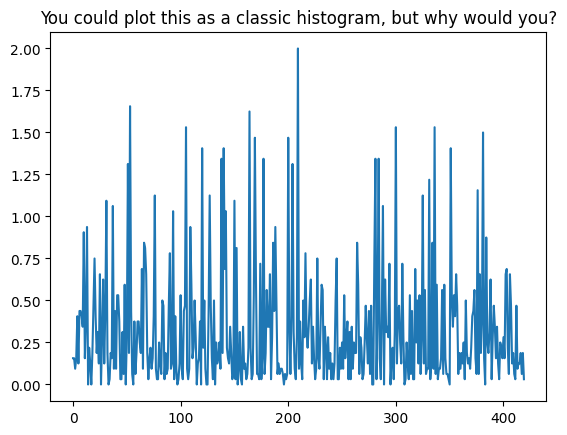

In [8]:
plt.clf()
plt.plot(cert_rs.numpy())
plt.title("You could plot this as a classic histogram, but why would you?")

In [9]:
r_max = 2.0
num_samples = cert_rs.size(0)
r_ticks = torch.arange(start=0.0, end=2.0, step=0.01)
accum_cert = torch.tensor([(cert_rs > rt).sum() / num_samples for rt in r_ticks])
accum_cert_and_correct = torch.tensor([((cert_rs > rt) * corrects).sum() / num_samples for rt in r_ticks])

Text(0.5, 1.0, "The 'cumulative version' overall thing looks something closer to this")

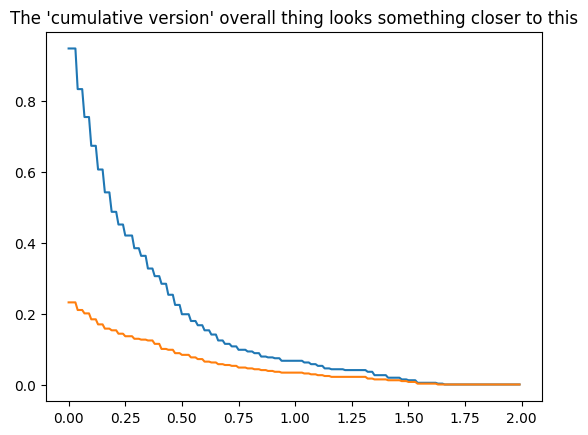

In [10]:
plt.clf()
plt.plot(r_ticks.numpy(), accum_cert.numpy())
plt.plot(r_ticks.numpy(), accum_cert_and_correct.numpy())
plt.title("The 'cumulative version' overall thing looks something closer to this")